In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Training Data

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Manipulation

In [3]:
def wrangle_data(df):
    df = df.assign(Mrs = df["Name"].str.contains("Mrs. ", case=False))
    df = df.assign(Mr = df["Name"].str.contains("Mr. ", case=False))
    return df
    
train_data = wrangle_data(train_data)
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Mrs,Mr
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,True


## Split Data

In [4]:
from sklearn.model_selection import train_test_split

y = train_data["Survived"]

features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Mrs", "Mr"]
X = train_data[features]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)


## Missing Values

We can see age has 177 missing values, Cabin 687, and Embarked 2 so these are the colunms we will want to look at closer. 

In [5]:
print(X_train.isnull().sum())


Pclass        0
Sex           0
Age         139
SibSp         0
Parch         0
Fare          0
Embarked      2
Mrs           0
Mr            0
dtype: int64


## Age 

From the plot below we can see there is some skewness  in the distributions of Age so I am going to fill missing values using the median.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Ages in Training Data'}, xlabel='Age', ylabel='Count'>

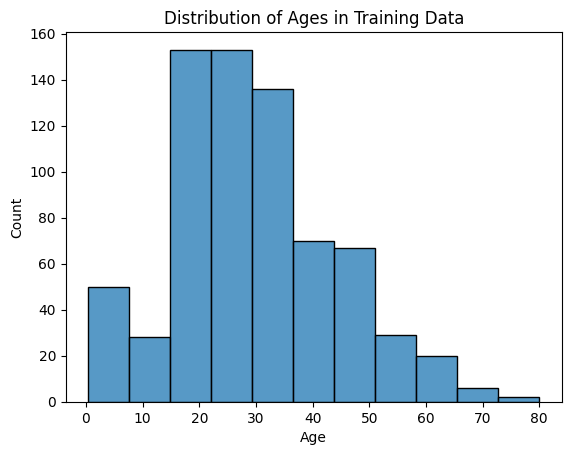

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.title("Distribution of Ages in Training Data")
sns.histplot(train_data["Age"].dropna(), bins=11)


## Fill Missing

In [7]:
# Get fill values
median_age = X_train["Age"].median()
most_freq_embark = X_train["Embarked"].mode()[0]

# Fill missing
X_train.loc[:, "Age"] = X_train["Age"].fillna(median_age)
X_train.loc[:, "Embarked"] = X_train["Embarked"].fillna(most_freq_embark)
X_val.loc[:, "Age"] = X_val["Age"].fillna(median_age)


## Model Selection

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train_dummies = pd.get_dummies(X_train)
X_val_dummies = pd.get_dummies(X_val)


In [9]:
for i in range(50, 550, 50):
    model = RandomForestClassifier(n_estimators=i, max_depth=10, random_state=123)
    model.fit(X_train_dummies, y_train)
    train_predictions = model.predict(X_val_dummies)
    print(i, f1_score(y_val, train_predictions))

50 0.8
100 0.8
150 0.8074534161490684
200 0.8
250 0.8074534161490684
300 0.8074534161490684
350 0.8
400 0.8074534161490684
450 0.8024691358024691
500 0.8074534161490684


In [10]:
for i in range(5, 20, 1):
    model = RandomForestClassifier(n_estimators=450, max_depth=i, random_state=123)
    model.fit(X_train_dummies, y_train)
    train_predictions = model.predict(X_val_dummies)
    print(i, f1_score(y_val, train_predictions))

5 0.7770700636942677
6 0.7692307692307692
7 0.7547169811320756
8 0.7924528301886793
9 0.8125
10 0.8024691358024691
11 0.7975460122699387
12 0.7975460122699387
13 0.7926829268292684
14 0.7738095238095238
15 0.7692307692307693
16 0.760233918128655
17 0.760233918128655
18 0.760233918128655
19 0.760233918128655


## Clean Data

In [11]:
# Load testing data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data = wrangle_data(test_data)
print(test_data.isnull().sum())

# Get fill values
medan_fare = X["Fare"].median()
median_age = X["Age"].median()
most_freq_embark = X["Embarked"].mode()[0]

# Fill missing
X.loc[:, "Age"] = X["Age"].fillna(median_age)
X.loc[:, "Embarked"] = X["Embarked"].fillna(most_freq_embark)
test_data.loc[:, "Age"] = test_data["Age"].fillna(median_age)
test_data.loc[:, "Fare"] = test_data["Fare"].fillna(medan_fare)


X_dumies = pd.get_dummies(X)
test_data_dummies = pd.get_dummies(test_data[features])



PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Mrs              0
Mr               0
dtype: int64


## Final Model

In [12]:
final_model = RandomForestClassifier(n_estimators=450, max_depth=9, random_state=123)
final_model.fit(X_dumies, y)

print("Final Model has 450 estimators and a max depth of 9")

Final Model has 450 estimators and a max depth of 9


## Final Predictions

In [13]:
predictions = final_model.predict(test_data_dummies)

output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived': predictions})

output.to_csv('submission.csv', index=False)